In [5]:
import numpy as np
import scipy.sparse as sp
import ReservoirComputer3_2 as ReCom
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import ipywidgets as widgets
from scipy.interpolate import splprep, splev
from scipy import stats
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import cm
import ReservoirPlot as resplt
import copy

In [6]:
class IPESN(ReCom.SPESN):
    def __init__(self, N, p, d, rho, sigma, gamma, beta, eta_i, epochs_i, eta_s=0, epochs_s=0, mu=0, sd=0.5, seed=1):
        ReCom.SPESN.__init__(self, N, p, d, rho, sigma, gamma, beta, eta_s, epochs_s, seed)
        self.eta_i = eta_i
        self.epochs_i = epochs_i
        self.mu=mu
        self.sd=sd
        self.a = np.ones(N)
        self.b = np.zeros(N)
    
    
    def f_PR(self, r, t, *args):
        v = self.W_out.dot(self.q(r))
        f = self.gamma*(-r + np.tanh(self.M.dot(r) + self.W_in.dot(v) + self.b))
        return np.squeeze(np.asarray(f))
    
    
    def f_LR(self, r, t, *args):
        f = self.gamma*(-r + np.tanh(self.M.dot(r) + self.W_in.dot(self.u(t)) + self.b))
        return np.squeeze(np.asarray(f))
    
    
    def H(self, x):
        return -self.mu/self.sd**2 + (x/self.sd**2)*(2*self.sd**2 + 1 - x**2 + self.mu*x)
    
    
    def IP_train(self, data, t_points, t_listen, reset_M=True, store_values=False):
        # If reset_M==True, change M, W_in, a and b to original values. 
        if reset_M:
            self.rho = self.rho
            self.sigma = self.sigma
            self.a = np.ones(self.N)
            self.b = np.zeros(self.N)
            
        if store_values:
            a_list = np.zeros((self.epochs_i, t_points.size-t_listen, self.N))
            b_list = np.zeros((self.epochs_i, t_points.size-t_listen, self.N))
            delta_a_list = np.zeros((self.epochs_i, t_points.size-t_listen, self.N))
            delta_b_list = np.zeros((self.epochs_i, t_points.size-t_listen, self.N))
            a_list[0, 0] = copy.deepcopy(self.a)
            b_list[0, 0] = copy.deepcopy(self.b)
        self.u = self.spline(data, t_points)

        
        for e in range(self.epochs_i):
            if store_values:
                a_list[e, 0] = copy.deepcopy(self.a)
                b_list[e, 0] = copy.deepcopy(self.b)
            x = integrate.odeint(self.f_LR, np.zeros(self.N), t_points)
            z = np.asarray([self.M.dot(x[t]) + self.W_in.dot(self.u(t_points[t])) for t in range(len(t_points))])
            for t in range(t_listen, data.shape[0]-1):
                delta_b = -self.eta_i*self.H(x[t])
                delta_a = self.eta_i/self.a + np.dot(np.diag(delta_b), z[t])
                self.b += delta_b
                self.a += delta_a
                if store_values:
                    a_list[e, t-t_listen+1] = copy.deepcopy(self.a)
                    b_list[e, t-t_listen+1] = copy.deepcopy(self.b)
                    delta_a_list[e, t-t_listen] = copy.deepcopy(delta_a)
                    delta_b_list[e, t-t_listen] =copy.deepcopy(delta_b)
                    
                    
        self.M = self.rho*np.matmul(np.diag(self.a), self.M.todense())
        self.W_in = self.sigma*np.matmul(np.diag(self.a), self.W_in.todense())
        if store_values:
            return a_list, b_list, delta_a_list, delta_b_list

In [7]:
def lorenz(u, *args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = alpha[0], alpha[1], alpha[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])

T_train = 100
T_predict = 150
dt = 0.01
alpha = (8.0/3.0, 28.0, 10.0)
x0 = np.asarray([1.0, 1.0, 1.0])
t_points_training = np.linspace(0, T_train, int(T_train/dt))
t_points_prediction = np.linspace(0, T_predict, int(T_predict/dt))
train_data = integrate.odeint(lorenz, x0, t_points_training, args=alpha)
val_data = integrate.odeint(lorenz, train_data[-1], t_points_prediction, args=alpha)

In [8]:
RC = IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=1e-5, epochs_i=12, eta_s=0, epochs_s=0)

In [9]:
a_list, b_list, delta_a_list, delta_b_list = RC.IP_train(train_data, t_points_training, t_listen=5000, store_values=True)
ip_train_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction_ip = RC.predict(t_points_prediction)

In [10]:
a_list_epoch = a_list.reshape(12*5000, 100)
b_list_epoch = b_list.reshape(12*5000, 100)

In [11]:
%matplotlib inline
@widgets.interact(i=(0, 100, 1))
def update(i=0):
    fig, ax = plt.subplots(4, 3, figsize=(15,10))
    ax[0, 0].plot(a_list[0, :, i])
    ax[0, 1].plot(a_list[1, :, i])
    ax[0, 2].plot(a_list[2, :, i])

    ax[1, 0].plot(a_list[3, :, i])
    ax[1, 1].plot(a_list[4, :, i])
    ax[1, 2].plot(a_list[5, :, i])

    ax[2, 0].plot(a_list[6, :, i])
    ax[2, 1].plot(a_list[7, :, i])
    ax[2, 2].plot(a_list[8, :, i])

    ax[3, 0].plot(a_list[9, :, i])
    ax[3, 1].plot(a_list[10, :, i])
    ax[3, 2].plot(a_list[11, :, i])

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

In [195]:
%matplotlib inline
@widgets.interact(i=(0, 100, 1), xlim=(0,4000,10), y=(0,1,0.1))
def update(i=0, xlim=150, y=0.1):
    steps = np.arange(0, 5000)

    for k in range(10):
        plt.plot(steps + k*5000, a_list[k, :, i])
    
    plt.ylim(0, y)

interactive(children=(IntSlider(value=0, description='i'), IntSlider(value=150, description='xlim', max=4000, …

(0.02, 0.1)

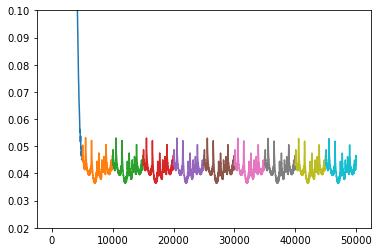

In [198]:
i= 17
m = 10**(-8)
steps = np.arange(0, 5000)

for k in range(10):
    plt.plot(steps + k*5000, a_list[k, :, i])
    
plt.ylim(0.02, 0.1)

Text(0.5, 0.98, 'Evolution of Gain and Bias During Training')

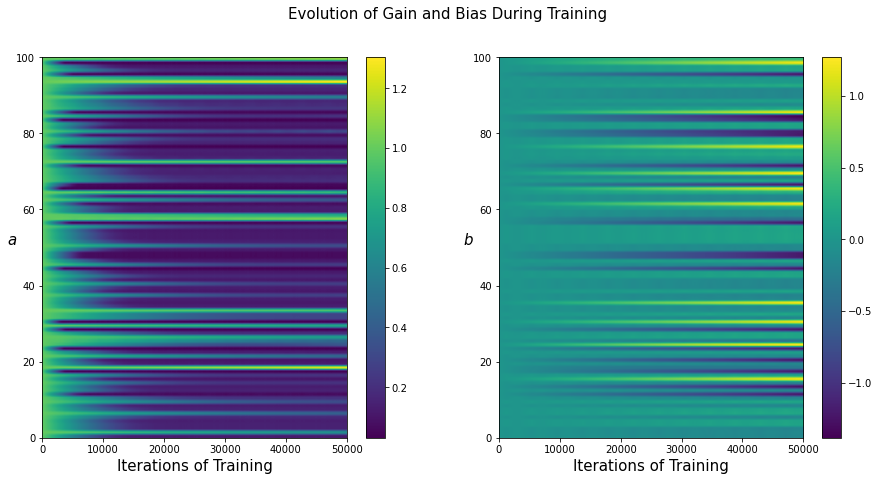

In [226]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

im1 = ax[0].imshow(a_list_epoch.T,
               origin='lower', extent=[0, 50000, 0, 100],
               vmax=a_list_epoch.max(), vmin=a_list_epoch.min(),
               aspect='auto',
               cmap=plt.cm.get_cmap('viridis'))

im2 = ax[1].imshow(b_list_epoch.T,
               origin='lower', extent=[0, 50000, 0, 100],
               vmax=b_list_epoch.max(), vmin=b_list_epoch.min(),
               aspect='auto',
               cmap=plt.cm.get_cmap('viridis'))

fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_xlabel('Iterations of Training', fontsize=15)
ax[0].set_ylabel('$a$', fontsize=15, rotation=False)
ax[1].set_xlabel('Iterations of Training', fontsize=15)
ax[1].set_ylabel('$b$', fontsize=15, rotation=False)
fig.suptitle('Evolution of Gain and Bias During Training', fontsize=15)

In [12]:
RC = IPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta_i=1e-5, epochs_i=5, eta_s=0, epochs_s=0)
train_traj = RC.train(train_data, t_points_training, t_listen=5000)

In [13]:
RC.IP_train(train_data, t_points_training, t_listen=5000)
ip_train_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction_ip = RC.predict(t_points_prediction)

Text(0.5, 0.98, 'Effect of Applying IP Rule on Distribution of Reservoir Node States ')

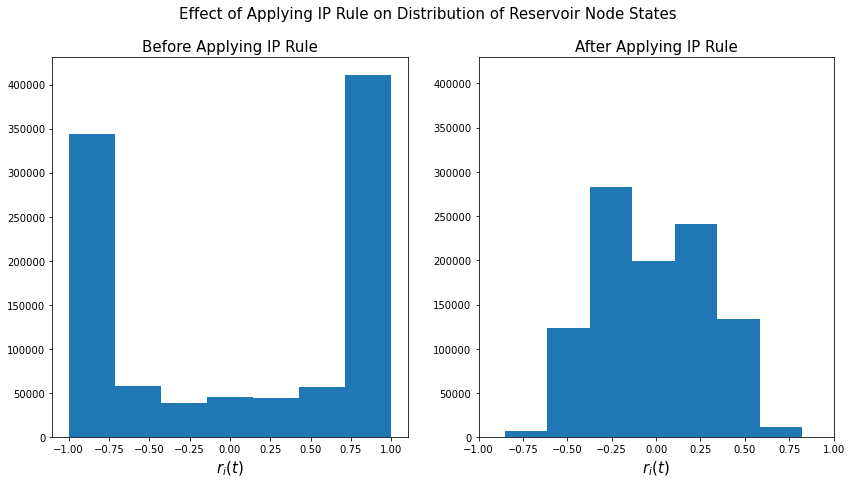

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.hist(train_traj.flatten(),bins=7)
ax2.hist(ip_train_traj.flatten(), bins=7)
ax1.set_xlabel('$r_{i}(t)$', fontsize=15)
ax2.set_xlabel('$r_{i}(t)$', fontsize=15)
ax2.set_ylim(0, 430000)
ax2.set_xlim(-1, 1)
ax1.set_title('Before Applying IP Rule', fontsize=15)
ax2.set_title('After Applying IP Rule', fontsize=15)
fig.suptitle('Effect of Applying IP Rule on Distribution of Reservoir Node States ', fontsize=15)
